## Import image

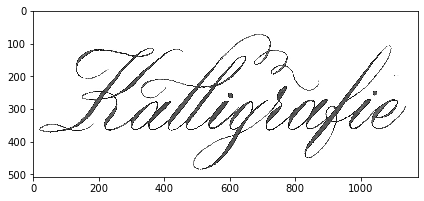

In [1]:
from skimage.io import imread, imshow

image_scan = imread('test-files/kalligrafie.png', as_gray=True)
imshow(image_scan)

## Convert image to binary

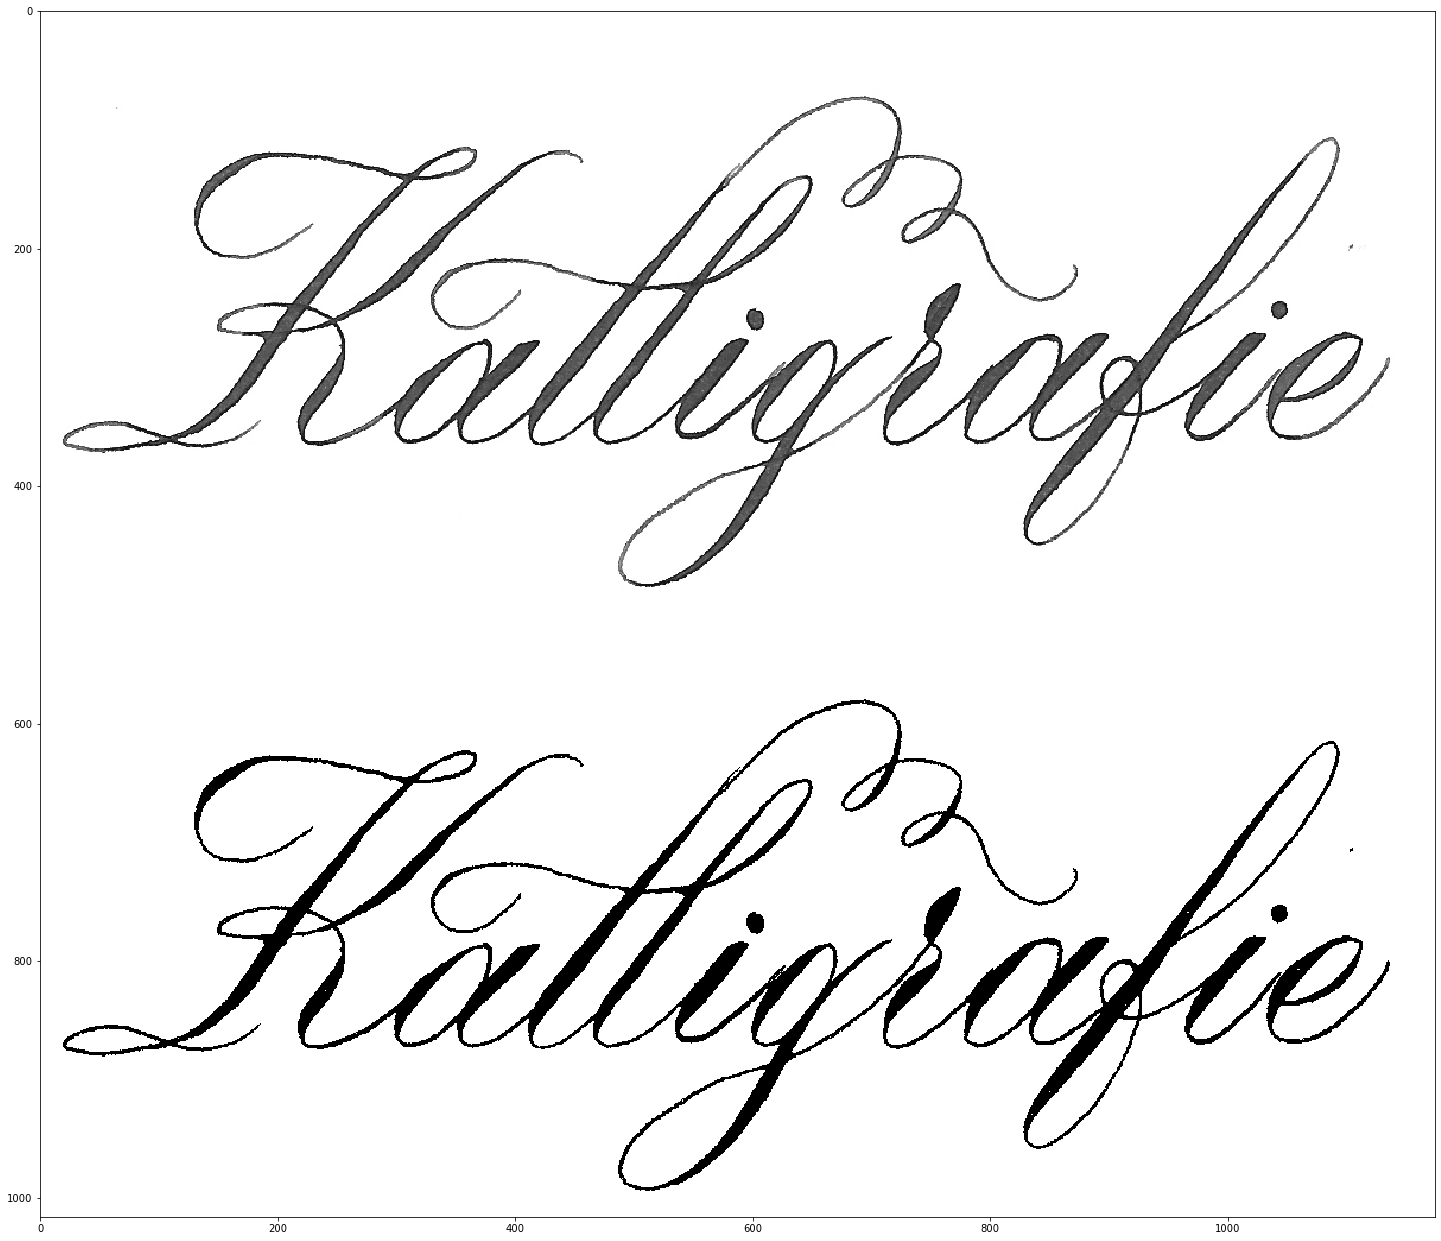

In [2]:
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

# Set display size of all plt plots
plt.rcParams['figure.figsize'] = (25, 25)

# Use Otsu's thresholding method to determine the threshold
threshold = threshold_otsu(image_scan)

# Create binary image
image_binary = image_scan > threshold

# Show the grayscale and binary image
plt.imshow(np.vstack((image_scan, image_binary)), cmap='gray', interpolation='nearest')

## Remove islands

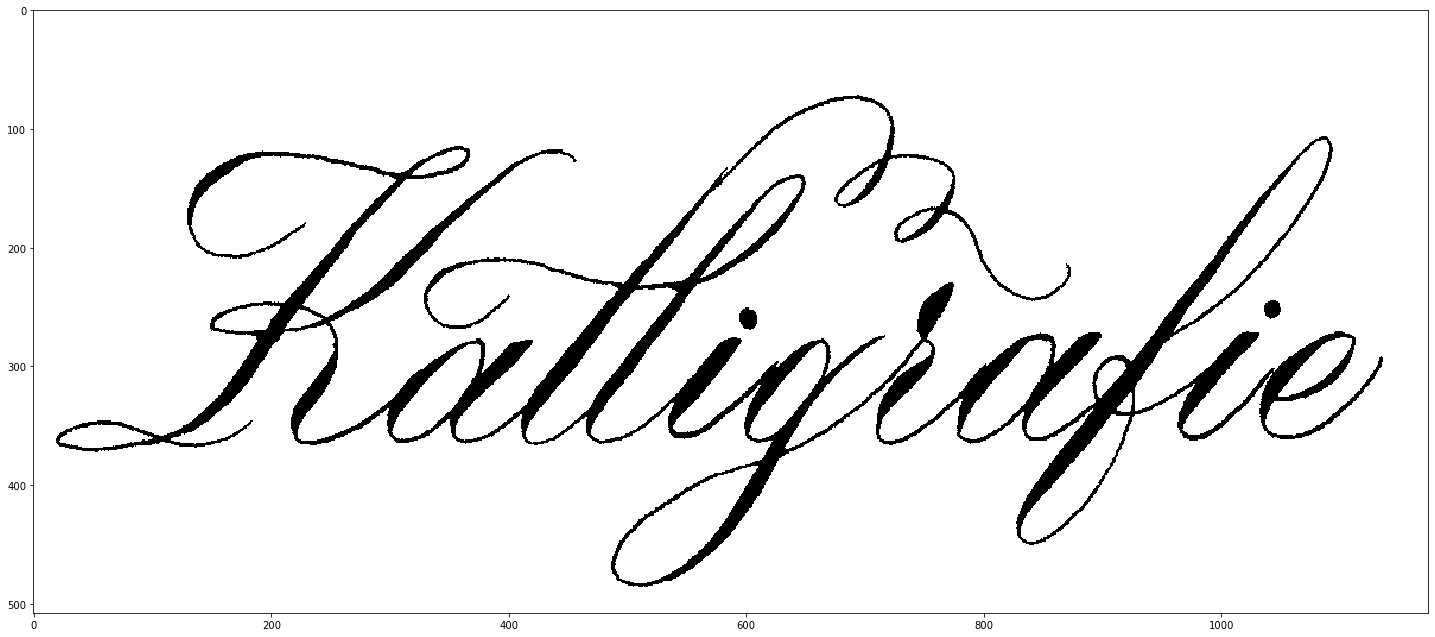

In [3]:
import skimage.morphology as mrp

# Use morphology methods to close small holes and open (remove) small pixel islands
image_cleaned = mrp.remove_small_holes(image_binary)
image_cleaned = mrp.remove_small_objects(image_cleaned)

plt.imshow(image_cleaned, cmap='gray', interpolation='nearest')

## Trace contours

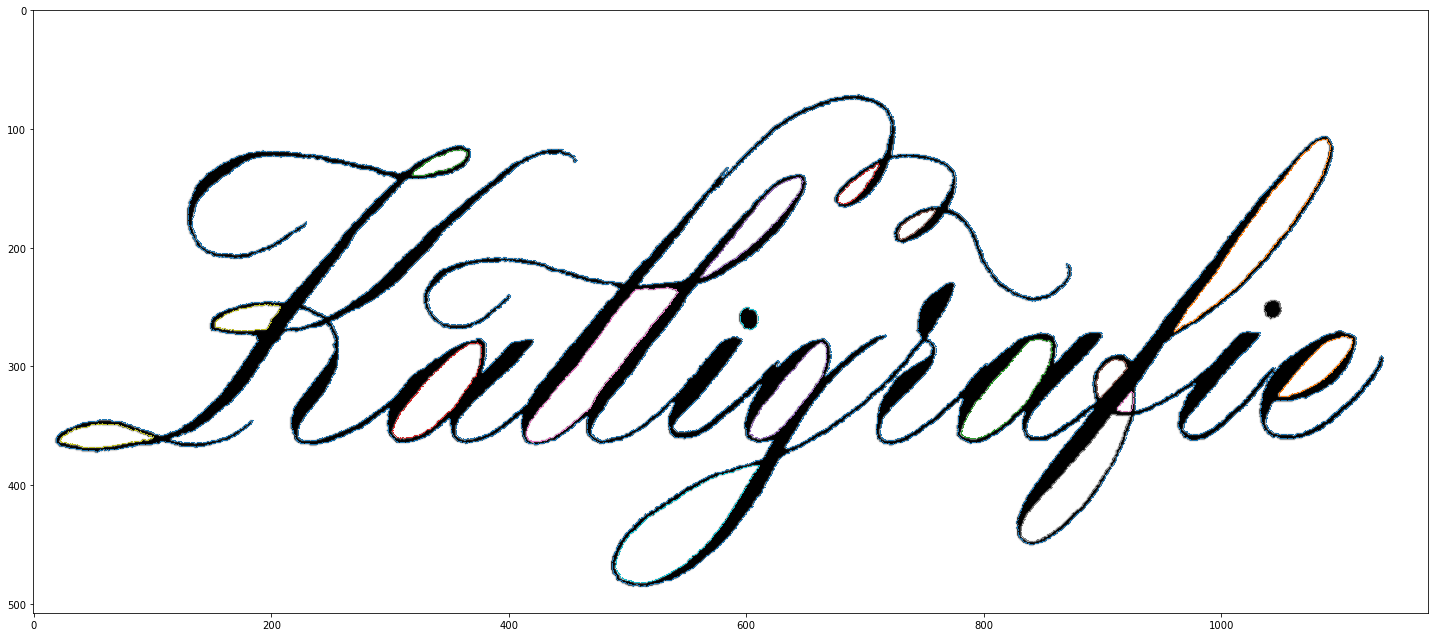

In [4]:
from skimage import measure
from skimage import filters

# Apply gaussian filter to slightly smoothen the edges
image_smoothened = filters.gaussian(image_cleaned, 0.5)

# Trace contours using skimage
contours = measure.find_contours(image_smoothened)

# Round contours to 1 decimal
for i, contour in enumerate(contours):
    contours[i] = np.round(contour, 1)

# Display the image and plot all contours
fig, ax = plt.subplots()
ax.imshow(image_smoothened, cmap='gray')
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], marker=',', linestyle='none')

## Detect corners


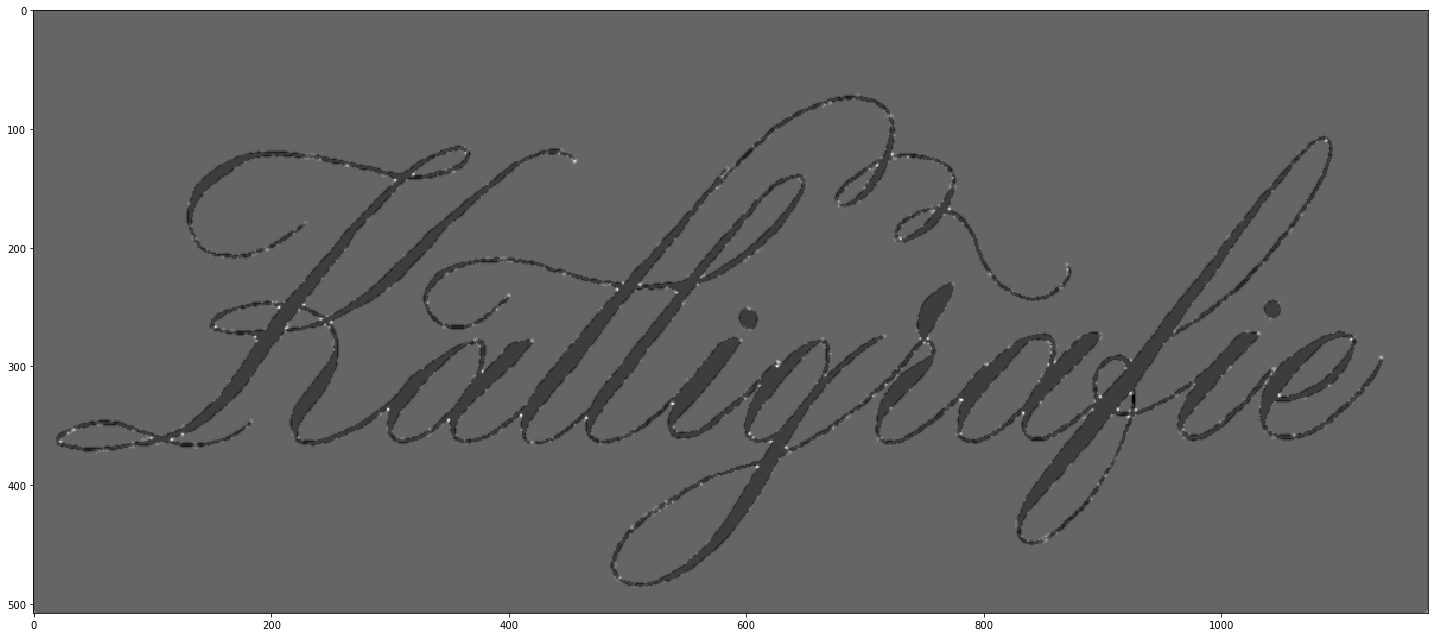

In [5]:
from skimage.feature import corner_harris

# Detect corners using the harris corner detector
corners_harris = corner_harris(image_cleaned)

# Show the harris corner values on the image
fig, ax = plt.subplots()
ax.imshow(image_cleaned, cmap='gray', interpolation='nearest')
ax.imshow(corners_harris, cmap='gray', interpolation='nearest', alpha=0.85)

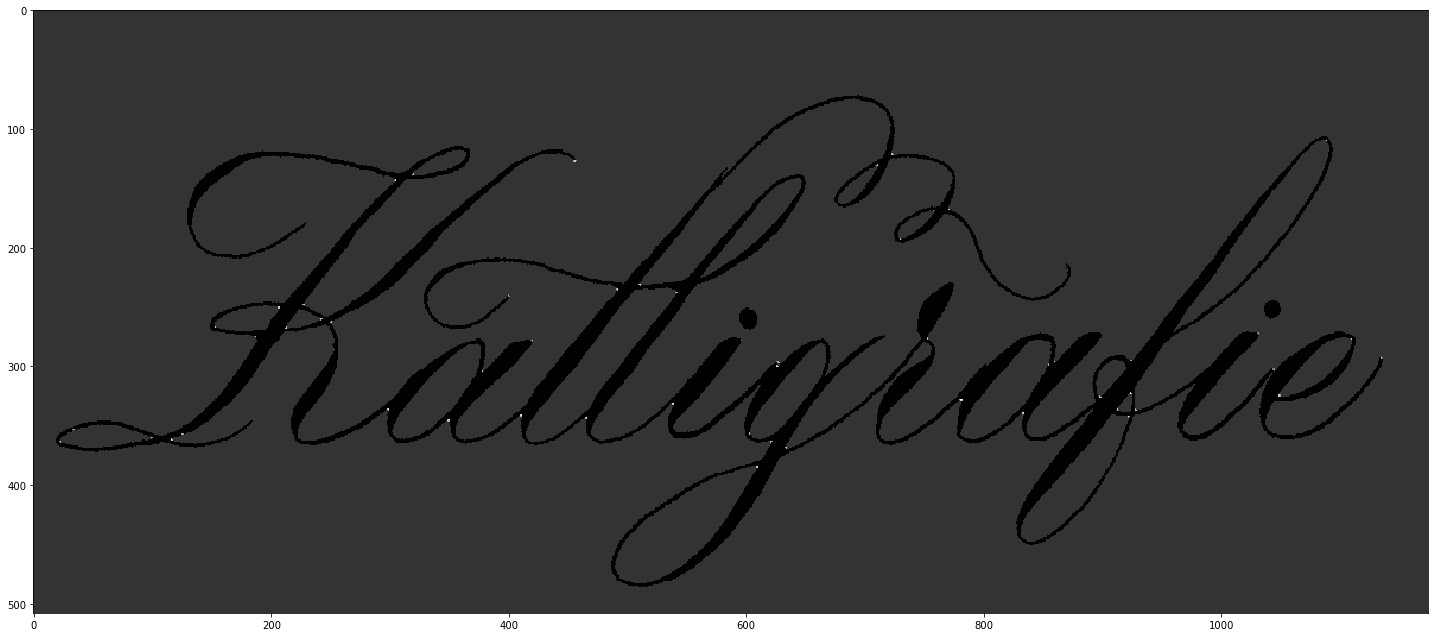

In [6]:
# Filter the brightest spots (highest harris corner value)
corner_threshold = 15
corners_harris[corners_harris < corner_threshold] = 0

# Show the remaining pixels on the image
fig, ax = plt.subplots()
ax.imshow(image_cleaned, cmap='gray', interpolation='nearest')
ax.imshow(corners_harris, cmap='gray', interpolation='nearest', alpha=0.8)

In [7]:
from skimage.feature import peak_local_max

# Get the brightest pixel of each harris corner pixel group
corners_points = peak_local_max(corners_harris)

# Convert contours to 2D array of pixel pairs
contours_combined = np.asarray([pixel for contour in contours for pixel in contour])

## Move corners onto contour

[127 456] moved to [128.  456.5]
[328 781] moved to [327.5 781. ]
[300 626] moved to [300.4 626. ]
[343 466] moved to [342.6 466. ]
[336 299] moved to [335.6 299. ]
[339 834] moved to [338.6 834. ]
[331 539] moved to [330.6 539. ]
[296 627] moved to [296.  627.4]
[341 411] moved to [340.6 411. ]
[250 207] moved to [249.6 207. ]
[384 610] moved to [383.6 610. ]
[345 350] moved to [344.6 350. ]
[ 293 1135] moved to [ 292.5 1136. ]
[362 116] moved to [362.4 116. ]
[323 924] moved to [322.5 925. ]
[122 723] moved to [122.  722.6]
[337 928] moved to [337.4 928. ]
[326 898] moved to [326.4 898. ]
[144 305] moved to [144.  305.4]
[263 251] moved to [262.  250.5]
[ 277 1110] moved to [ 276.6 1110. ]
[ 325 1049] moved to [ 325.4 1049. ]
[235 492] moved to [235.  492.4]
[ 272 1032] moved to [ 271.6 1032. ]
[278 420] moved to [278.  420.4]
[ 110 1089] moved to [ 109.6 1089. ]
[268 213] moved to [268.5 213. ]
[267 153] moved to [267.4 153. ]
[337 913] moved to [337.4 913. ]
[357 603] moved to [357

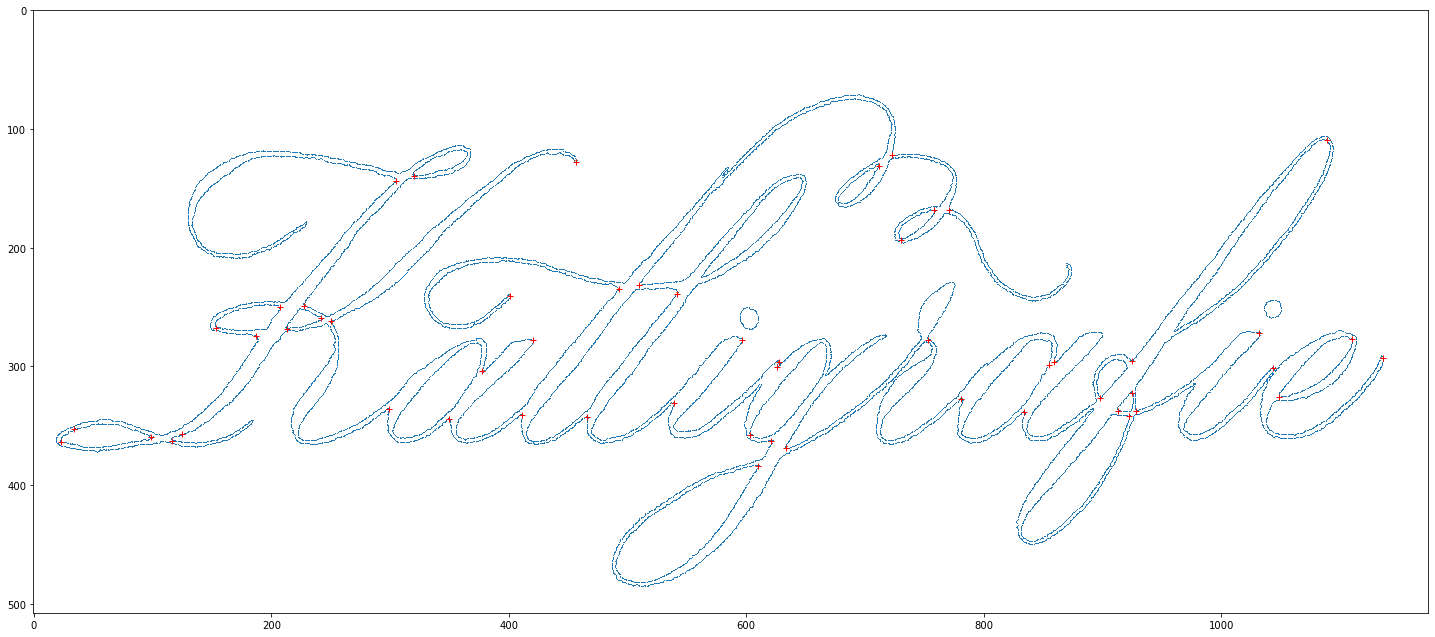

In [8]:
corners_corrected = []

# From a corner peak local max go in x, y until contour reached
# (max. 5 px, otherwise outside corner -> fallback to the closest contour point)
contour_search_distance = 5

for corner in corners_points:
    # Skip if already on contour
    if any(np.equal(contours_combined, corner).all(1)):
        print('skipped')
        continue

    x = corner[1]
    y = corner[0]
    x_direction = 0
    y_direction = 0
    x_corr = 0
    y_corr = 0

    for i in range(1, contour_search_distance * 10 + 1):
        # Search x
        if x_direction == 0:
            if any(np.equal(contours_combined, [y, x + i / 10]).all(1)):
                x_direction = 1
                x_corr = i / 10
            elif any(np.equal(contours_combined, [y, x - i / 10]).all(1)):
                x_direction = -1
                x_corr = -i / 10

        # Search y
        if y_direction == 0:
            if any(np.equal(contours_combined, [y + i / 10, x]).all(1)):
                y_direction = 1
                y_corr = i / 10
            elif any(np.equal(contours_combined, [y - i / 10, x]).all(1)):
                y_direction = -1
                y_corr = -i / 10

    # Move corner
    if x_direction != 0 and y_direction != 0:
        for i in range(1, contour_search_distance * 10 + 1):
            x_corr = x + (i / 10 * x_direction)
            y_corr = y + (i / 10 * y_direction)
            # Move diagonal
            closest_pixel = np.sum(np.abs(np.subtract(contours_combined,[y_corr, x_corr])), axis=1).argmin()
            # As contour pixels are maximum 1 px apart, accepted contour pixel needs to be max 0.5 away
            if np.less_equal(np.abs(np.subtract(contours_combined[closest_pixel], [y_corr, x_corr])), [.5, .5]).all():
                corners_corrected.append(contours_combined[closest_pixel])
                print(f'{corner} moved to {contours_combined[closest_pixel]}')
                break
        else:
            print(f'{corner} could not be moved to contour.')

    # Fallback to initial solution for outside corners
    else:
        print('fallback', x_direction, y_direction)
        distances = np.sqrt((contours_combined[:, 0] - y) ** 2 + (contours_combined[:, 1] - x) ** 2)
        corners_corrected.append(contours_combined[np.argmin(distances)])

# Convert to numpy array
corners_corrected = np.asarray(corners_corrected)

# Show corners and corrected corners on the contour
fig, ax = plt.subplots()
ax.imshow(image_cleaned, alpha=0)  # invisible, only for shape of plot
ax.plot(contours_combined[:, 1], contours_combined[:, 0], linestyle='none', marker=',')
ax.plot(corners_points[:, 1], corners_points[:, 0], linestyle='none', marker=',')
ax.plot(corners_corrected[:, 1], corners_corrected[:, 0], 'r+')

## Split by corners

In [9]:
def split_contour_by_corners(contour, corners):
    segments = []
    first_segmentation_index = -1
    last_segmentation_index = 0
    has_corner = False

    # Search contour for matching corner
    for i, pixel in enumerate(contour):
        for j, corner in enumerate(corners):
            # If a corner is found, create a new segment
            if np.array_equal(corner, pixel):
                segments.append(contour[last_segmentation_index:(i + 1)])
                has_corner = True
                last_segmentation_index = i
                if first_segmentation_index == -1:
                    first_segmentation_index = i

    # Combine first and last segment to one segment and set start point to a corner point
    if first_segmentation_index > 0:
        combined_segment = list(contour[last_segmentation_index:len(contour) - 1]) + list(segments[0])
        segments.append(combined_segment)
        segments.pop(0)
    # Handle special case when start point already is a corner
    elif first_segmentation_index == 0:
        segments.pop(0)
    # If there is no corner found, take contour as segment
    else:
        segments.append(contour)

    return segments, has_corner


contours_in_segments = []
contour_has_corner = []
for contour in contours:
    segments, has_corner = split_contour_by_corners(contour, corners_corrected)
    contours_in_segments.append(segments)
    contour_has_corner.append(has_corner)


## Curve fitting

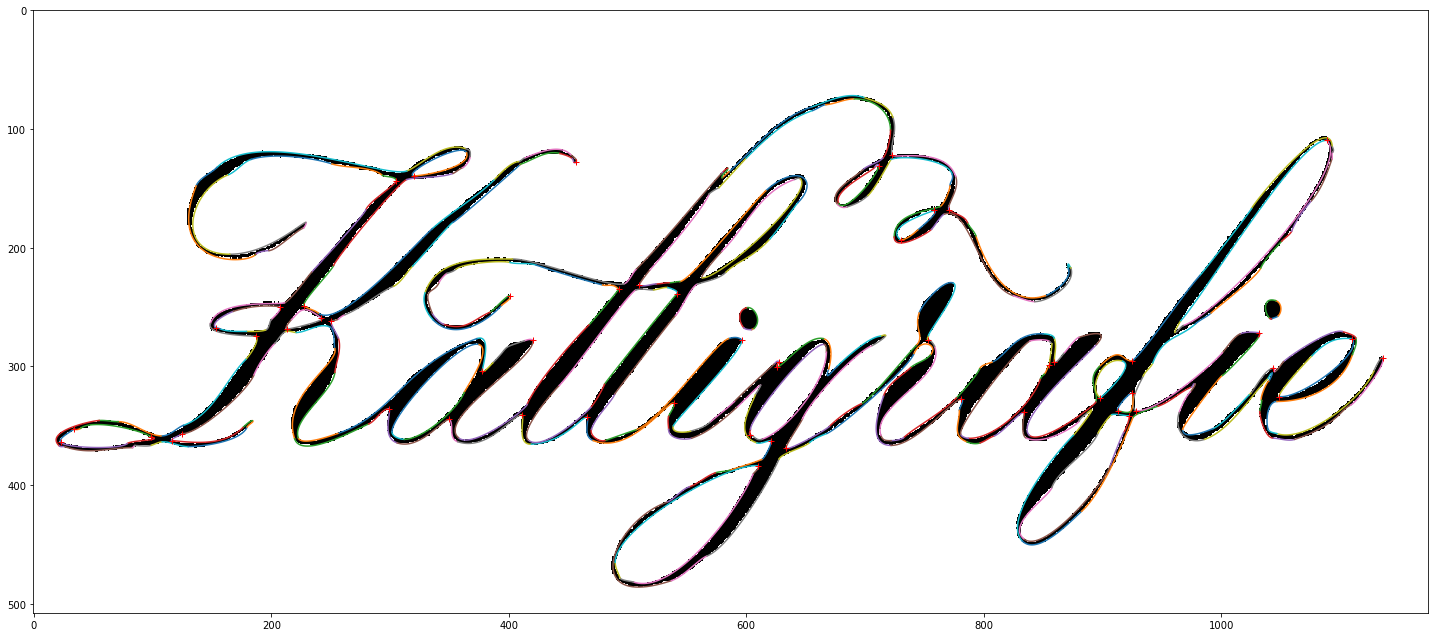

In [10]:
from libraries.fitCurves.fitCurves import *
from libraries import svg

# Parameters for Bézier fitting
maxError = 3
splitError = 30
minIterationsBeforeSplit = 10

# Prepare plot
fig, ax = plt.subplots()
# Use original image as background
ax.imshow(image_cleaned, cmap='gray', interpolation='nearest')

# Prepare SVG
svg_file = svg.create_file('test-files/referenceResult.svg', np.shape(image_cleaned)[1], np.shape(image_cleaned)[0])
path_string = '\n'

for index, contour in enumerate(contours_in_segments):
    has_corner = contour_has_corner[index]
    svg_path = ''

    # Fit a composite cubic Bézier curve to each segment
    for i, segment in enumerate(contour):
        beziers = fitCurve(segment, has_corner, maxError, splitError, minIterationsBeforeSplit)

        # Add each cubic Bézier to the SVG path
        for j, bez in enumerate(beziers):
            bez = np.stack(bez)
            bez = np.round(bez, 2)

            # Build SVG path according to the specification
            if i == 0 and j == 0:
                svg_path = 'M{x0},{y0} C{x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                    x0=bez[0, 1],
                    y0=bez[0, 0],
                    x1=bez[1, 1],
                    y1=bez[1, 0],
                    x2=bez[2, 1],
                    y2=bez[2, 0],
                    x3=bez[3, 1],
                    y3=bez[3, 0]
                )
            else:
                svg_path += ', {x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                    x1=bez[1, 1],
                    y1=bez[1, 0],
                    x2=bez[2, 1],
                    y2=bez[2, 0],
                    x3=bez[3, 1],
                    y3=bez[3, 0]
                )

            # Plot the composite Bézier curve
            curve = []
            for t in np.linspace(0, 1, 50):
                curve.append(bezier.q(bez, t))
            curve = np.stack(curve)
            ax.plot(curve[:, 1], curve[:, 0])

    # Append the curve to the overall SVG path string
    path_string += f'{svg_path}Z\n'

# Show the corner points
ax.plot(corners_corrected[:, 1], corners_corrected[:, 0], 'r+')

# Add path to SVG file and save
svg.add_path_element(svg_file, path_string)
svg.save_file(svg_file)

plt.savefig('test-files/referenceResult.png', dpi=1200)